## Imports

In [1]:
import sys
sys.path.append('..')

import math, random, argparse, time, uuid
import os, os.path as osp
from helper import makeDirectory, set_gpu

import numpy as np
import torch
from torch.nn import functional as F
from sklearn.model_selection import KFold
from torch_geometric.data import DataLoader, Data, Batch, DenseDataLoader as DenseLoader
from torch_geometric.datasets import TUDataset, MoleculeNet
from torch_geometric.utils import subgraph
from syn_dataset import SynGraphDataset
from impo_model import IMPO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from logger import Logger
import numpy as np
from sklearn.metrics import f1_score
torch.backends.cudnn.benchmark = False

/home/spideralessio/.conda/envs/imp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

In [2]:
parser = argparse.ArgumentParser(description='Neural Network Trainer Template')

parser.add_argument('-model',       dest='model',               default='IMPO',                    help='Model to use')
parser.add_argument('-data',        dest='dataset',             default='PROTEINS', type=str,           help='Dataset to use')
parser.add_argument('-epoch',       dest='max_epochs',          default=100,        type=int,           help='Max epochs')
parser.add_argument('-l2',          dest='l2',                  default=5e-4,       type=float,         help='L2 regularization')
parser.add_argument('-num_layers',  dest='num_layers',          default=3,          type=int,           help='Number of GCN Layers')
parser.add_argument('-lr_decay_step',   dest='lr_decay_step',   default=50,         type=int,           help='lr decay step')
parser.add_argument('-lr_decay_factor', dest='lr_decay_factor', default=0.5,        type=float,         help='lr decay factor')
parser.add_argument('-eval_expl',        dest='eval_expl',                default=False,      type=bool,          help='whether eval expl')

parser.add_argument('-batch',       dest='batch_size',          default=128,        type=int,           help='Batch size')
parser.add_argument('-hid_dim',     dest='hid_dim',             default=64,         type=int,           help='hidden dims')
parser.add_argument('-dropout_att', dest='dropout_att',         default=0.1,        type=float,         help='dropout on attention scores')
parser.add_argument('-lr',          dest='lr',                  default=0.01,       type=float,         help='Learning rate')
parser.add_argument('-ratio',       dest='ratio',               default=0.5,        type=float,         help='ratio')
parser.add_argument('-num_clusters',dest='num_clusters',        default=2,          type=int,           help='num_clusters')
parser.add_argument('-heads',       dest='heads',               default=5,          type=int,           help='heads')
parser.add_argument('-lambda1',     dest='lambda1',             default=10,         type=float,         help='lambda1')
parser.add_argument('-lambda2',     dest='lambda2',             default=0.001,      type=float,         help='lambda2')
parser.add_argument('-gcn_normalize',   dest='gcn_normalize',   default=False,      type=bool,          help='gcn_normalize')


parser.add_argument('-folds',       dest='folds',               default=10,         type=int,               help='Cross validation folds (with 1 it only splits train/val/test)')

parser.add_argument('-name',        dest='name',                default='test_'+str(uuid.uuid4())[:8],  help='Name of the run')
parser.add_argument('-gpu',         dest='gpu',                 default='0',                            help='GPU to use')
parser.add_argument('-restore',     dest='restore',             action='store_true',                    help='Model restoring')

args = parser.parse_args("-data ba_2motifs -eval_expl True -batch 128 -hid_dim 128 -epoch 300 -heads 20 -num_clusters 1 -lr 0.001 -lambda1 10000 -lambda2 0.1 -l2 0.001 -folds 1 -gcn_normalize True -dropout_att 0.3 -lr_decay_factor 1".split())


In [3]:
logger = Logger('tmp')

In [4]:
from main import Trainer

In [5]:
!ls ../torch_saved

test_09b2a1cc_01_08_2023_09:42:10_run_0
test_09b2a1cc_01_08_2023_09:42:10_run_1
test_09b2a1cc_01_08_2023_09:42:10_run_10
test_09b2a1cc_01_08_2023_09:42:10_run_11
test_09b2a1cc_01_08_2023_09:42:10_run_12
test_09b2a1cc_01_08_2023_09:42:10_run_13
test_09b2a1cc_01_08_2023_09:42:10_run_14
test_09b2a1cc_01_08_2023_09:42:10_run_15
test_09b2a1cc_01_08_2023_09:42:10_run_16
test_09b2a1cc_01_08_2023_09:42:10_run_17
test_09b2a1cc_01_08_2023_09:42:10_run_18
test_09b2a1cc_01_08_2023_09:42:10_run_19
test_09b2a1cc_01_08_2023_09:42:10_run_2
test_09b2a1cc_01_08_2023_09:42:10_run_3
test_09b2a1cc_01_08_2023_09:42:10_run_4
test_09b2a1cc_01_08_2023_09:42:10_run_5
test_09b2a1cc_01_08_2023_09:42:10_run_6
test_09b2a1cc_01_08_2023_09:42:10_run_7
test_09b2a1cc_01_08_2023_09:42:10_run_8
test_09b2a1cc_01_08_2023_09:42:10_run_9


In [6]:
args.name = 'test_09b2a1cc_01_08_2023_09:42:10'

In [7]:
model       = Trainer(args)

/home/spideralessio/interpretable_memory_pooling_private/IMPO/./data/ba_2motifs


In [8]:
save_path = '../torch_saved/{}_run_0'.format(model.p.name)
model.model = model.addModel()
model.optimizer  = model.addOptimizer()
model.load_model(save_path)
print('Successfully Loaded previous model')

Successfully Loaded previous model


## Load Data and Plot Dataset Statistics

In [9]:
model.loadData()

/home/spideralessio/interpretable_memory_pooling_private/IMPO/./data/ba_2motifs


In [10]:
# Mean Nodes
np.mean([d.x.shape[0] for d in model.data])

25.0

In [11]:
# Std-Dev Nodes
np.std([d.x.shape[0] for d in model.data])

0.0

In [12]:
# Mean Edges
np.mean([d.edge_index.shape[1] for d in model.data])/2

25.48

In [13]:
# Std Edges
np.std([d.edge_index.shape[1]/2 for d in model.data])

0.5095095681142798

## Plot Assignment Scores

In [14]:
from torch_geometric.data import DataLoader
loader = DataLoader(model.data, 1, shuffle=False)
acts = [[[] for j in range(2)] for i in range(3)]
for batch in loader:
    c = batch.y.item()
    a, S, mask = model.model.forward_activations(batch.cuda())
    embs = model.model.embs(batch.cuda())[0].cpu().detach().numpy()
    val, idxs = S.cpu().detach().reshape(-1,3).max(-1)
    for v, idx, m in zip(val, idxs, mask[0]):
        if not m.item(): continue
        acts[idx][c].append(v)

/home/spideralessio/.conda/envs/imp/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


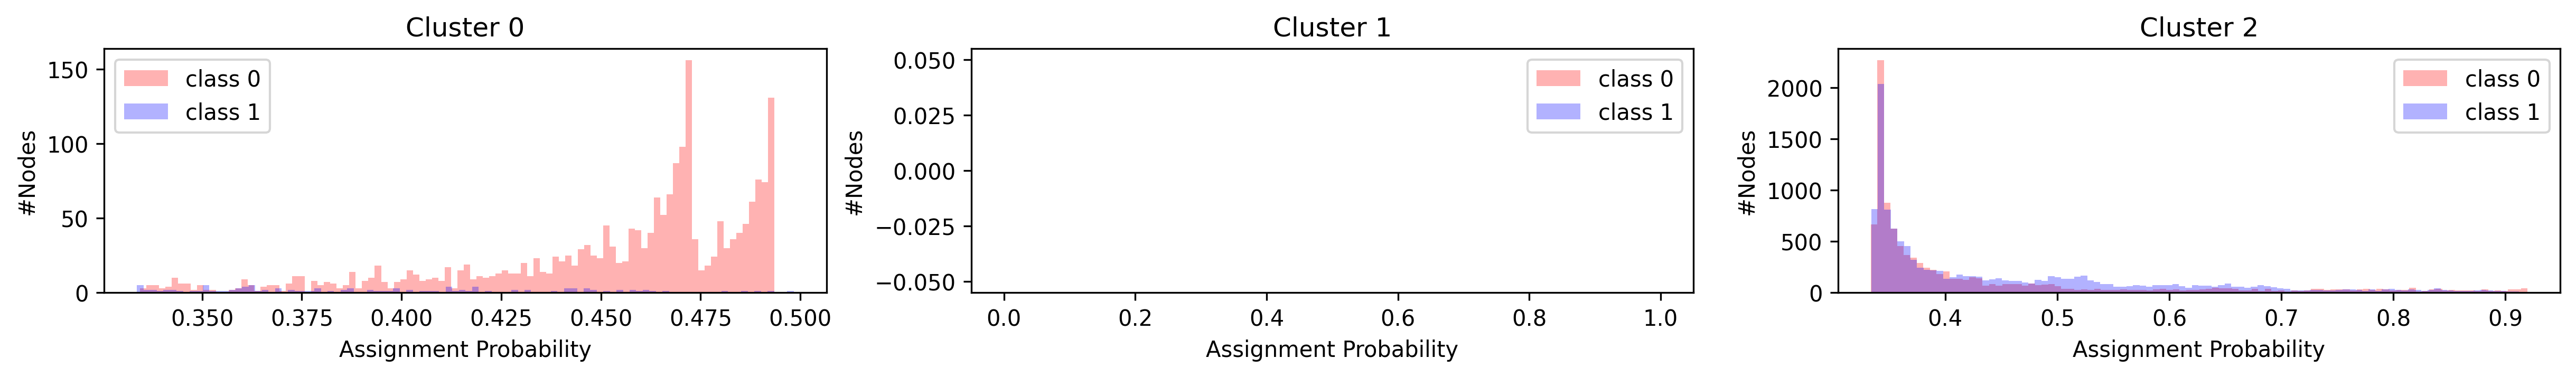

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(1,3, figsize=(20, 2))
colors = ["red","blue"]
for i in range(3):
    for j in [0,1]:
        axs[i].hist(acts[i][j], bins=100, alpha=0.3, color=colors[j], label=f"class {j}", zorder=j)
    axs[i].legend()
    axs[i].set_xlabel("Assignment Probability")
    axs[i].set_ylabel("#Nodes")
    axs[i].set_title(f"Cluster {i}")
plt.show()

## Visualize Explanation

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1.])


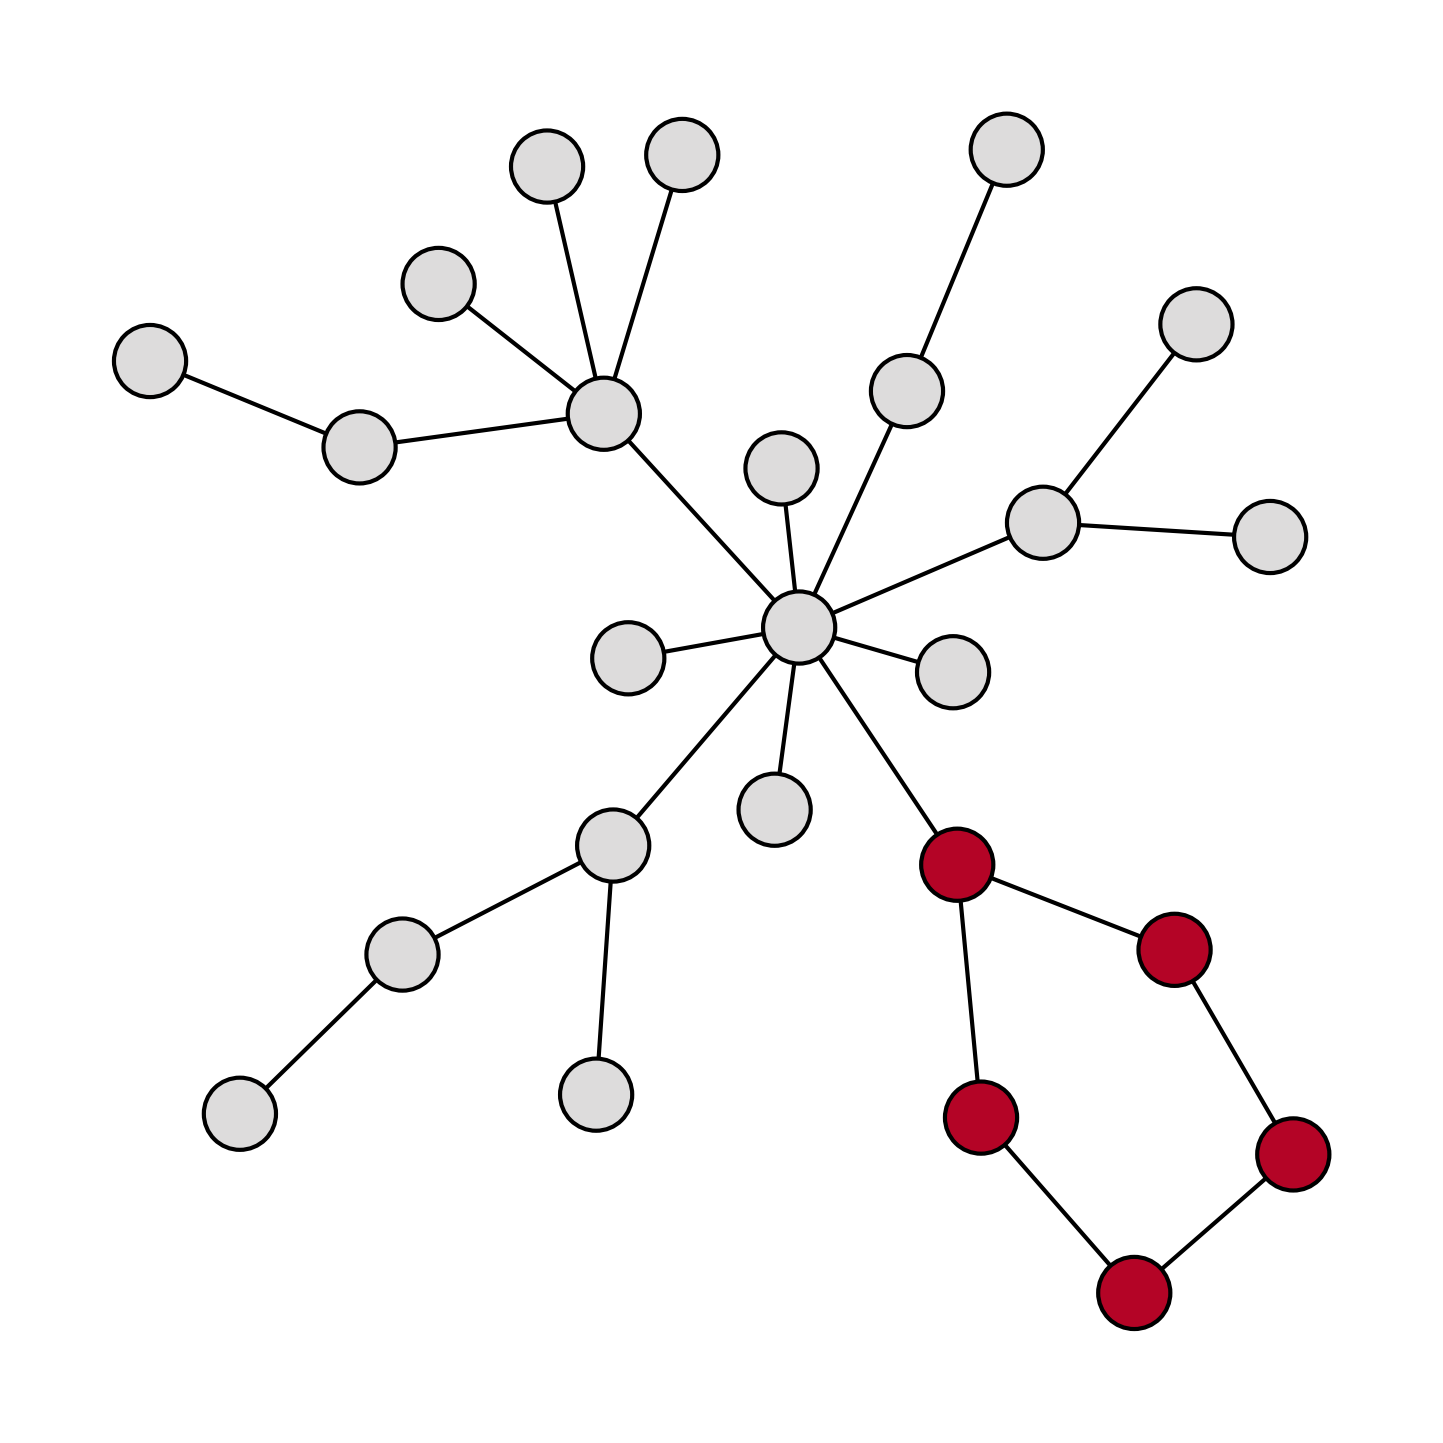

In [16]:
import matplotlib as mpl
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
import torch_geometric
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(6, 6))
data = model.data[1]
b = Batch.from_data_list([data])
o = model.model.forward_activations(b.cuda())
ind = o[1][0].argmax(-1)
e = torch.zeros((o[1].shape[1]))
e[ind==0]=1
e[ind==1] = -1
e[ind==2] = 0
print(e)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
pos = nx.kamada_kawai_layout(g)
nx.draw(g, node_color=e, pos=pos, vmin=-1, vmax=1, cmap='coolwarm', edgecolors='black', ax=ax)
fig.tight_layout(pad=5)
plt.show()